In [260]:
import pandas as pd
import json
import os
import ast
import re
from fuzzywuzzy import fuzz, process

In [340]:
import numpy as np
from sklearn.metrics import f1_score

def metrics_bootstrap_ci(group, n_bootstrap=1000, ci=0.95):
    y_true = group["class_label"].values
    y_pred = group["clean_prediction"].values
    is_correct = group["is_correct?"].values

    if len(group) <= 1:
        f1 = f1_score(y_true, y_pred, average="macro")
        acc = is_correct.mean()
        return pd.Series({
            "f1_score_mean": f1,
            "f1_score_ci_lower": f1,
            "f1_score_ci_upper": f1,
            "accuracy_mean": acc,
            "accuracy_ci_lower": acc,
            "accuracy_ci_upper": acc
        })

    f1_boot = []
    acc_boot = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(group), len(group), replace=True)
        f1_boot.append(f1_score(y_true[idx], y_pred[idx], average="macro"))
        acc_boot.append(is_correct[idx].mean())

    f1_lower = np.percentile(f1_boot, (1-ci)/2*100)
    f1_upper = np.percentile(f1_boot, (1+ci)/2*100)
    acc_lower = np.percentile(acc_boot, (1-ci)/2*100)
    acc_upper = np.percentile(acc_boot, (1+ci)/2*100)

    return pd.Series({
        "f1_score_mean": f1_score(y_true, y_pred, average="macro"),
        "f1_score_ci_lower": f1_lower,
        "f1_score_ci_upper": f1_upper,
        "accuracy_mean": is_correct.mean(),
        "accuracy_ci_lower": acc_lower,
        "accuracy_ci_upper": acc_upper
    })

results = merged.groupby(["medical_specialty"]).apply(metrics_bootstrap_ci).reset_index()


/tmp/user/25210/ipykernel_2020051/2349264524.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = merged.groupby(["medical_specialty"]).apply(metrics_bootstrap_ci).reset_index()


In [397]:
def extract_and_order_by_text(all_options, answer):
    """
    Extracts options found in the answer string and orders them based on
    their first appearance sequence in the answer string.
    """
    # 1. Find the starting index for every option found in the answer
    found_options_with_index = []

    ## Find option with index B) item
    for option in all_options:
        # str.find() returns the index of the first occurrence, or -1 if not found.
        index = answer.find(option)
        
        if index != -1:
            # Store the option along with its starting index
            found_options_with_index.append((index, option))
    if len(found_options_with_index) == 0:

    ##
         ## Find option without index B) item   -> item
        for option in all_options:
            # str.find() returns the index of the first occurrence, or -1 if not found.
            split = re.sub(r"^[A-Z]\)\s*", "", option)
            index = answer.find(split)
            
            if index != -1:
                # Store the option along with its starting index
                found_options_with_index.append((index, split))

    ##
    ## Find item with fuzzy wuzzy
    if len(found_options_with_index) == 0:
        for option in all_options:
            # Remove the leading "A) ", "B) ", etc.
            split = re.sub(r"^[A-Z]\)\s*", "", option)
        
            # Use fuzzy matching to compare the option with the answer
            match_score = fuzz.partial_ratio(split, answer)
            
            if match_score >= 80:  # threshold for considering it a match
                # Find approximate location using the best matching substring
                # Optional: use process.extractOne to get closest match in case answer has multiple lines
                found_options_with_index.append((match_score, split))
        


    # 2. Sort the list based on the index (the first item in the tuple)
    # This automatically sorts them in the order they appear in the text.
    found_options_with_index.sort(key=lambda item: item[0])
    
    # 3. Extract just the options (the second item in the tuple)
    extracted_list = [option for index, option in found_options_with_index]
    
    return extracted_list


def get_prediction(row):
    """
    Check if the correct answer is contained in the model's answer.
    Extend this function later for more complex logic.
    """
    all_options = ast.literal_eval(row["options"])
    correct_class = row["class_label"]
    correct_option = row["correct_answer_choice"]
    incorrect_options =[ option for option in all_options if correct_class not in option  ]
    
    model_answer =  row["answer"] 
  
    ### Calculate correctness
    selected_option = "None of the above"
    #import pdb;pdb.set_trace()
    #try:
        # When option is a letter (or  smaller than the correct answer) check if it matches the letter option
    if len(model_answer)  < len(correct_class):
        try:
            selected_option = [ item for item in all_options if model_answer in item]
            if len(selected_option) == 0:
                selected_option = "None of the above"
            else:
                selected_option = selected_option[-1].split(")")[-1].strip()
        except:
            pass
            #import pdb;pdb.set_trace()
       
            
    # When reasoning is performed: Make sure you get the last item
    
    elif len(model_answer)  > 1.05*len(correct_class):
            #import pdb;pdb.set_trace()
            extracted_list = extract_and_order_by_text(all_options, model_answer)
            if len(extracted_list) == 0:
                pass
            else:
                selected_option =  extracted_list[-1].split(")")[-1].strip()
   
            
    # Else try ig option matches the correct class label
    else:   
        selected_option = model_answer.split(")")[-1].strip()
    #except:
    #    pass

    # Basic containment check
    return selected_option 


def get_correctnes(row):
    """
    Check if the correct answer is contained in the model's answer.
    Extend this function later for more complex logic.
    """
    correct = 0
    
    all_options = ast.literal_eval(row["options"])
    correct_class = row["class_label"]
    correct_option = row["correct_answer_choice"]
    incorrect_options =[ option for option in all_options if correct_class not in option  ]
    

    # Exact match (option):
    if len(row["clean_prediction"]) < 5:
        if  correct_option in row["clean_prediction"]:
            correct = 1

    # Exact match (class):
    elif len(row["clean_prediction"]) ==  len(row["class_label"]):
        if row["clean_prediction"] == row["class_label"]:
            correct = 1
    elif len(row["clean_prediction"]) >  len(row["class_label"]):   
        is_incorrect_in_list = np.array([1 for item in incorrect_options if row["clean_prediction"] in  item ]).sum()
        if is_incorrect_in_list == 0:
            if correct_class in row["clean_prediction"]:
                correct = 1
                
    return correct





In [395]:
def get_random_prediction(row):
    """
    Randomly select one option as the model's prediction.
    """
    import random
    # Convert the string representation of list/dict into a Python object
    all_options = ast.literal_eval(row["options"])
    
    # Randomly choose one option
    selected_option = random.choice(all_options)
    
    return selected_option

In [262]:
task     = "all_cls"
data_root = f"/pasteur/u/rdcunha/data_cache/mmbu/final_data/VLMEvalData_v2/LMUData/all_cls/all_cls_closed_subsampled_with_label.tsv"

data = pd.read_csv(data_root,sep='\t')
filtered_ = data[data["question_type"] == "expert"]
df_ = filtered_[~filtered_["dataset"].isin([ "isic2018",'herlev',"breakhis_400x","breakhis_200x"])]
df_ = df_.rename(columns={"answer": "correct_answer_choice"})
df_["class_label"] = df_["class_label"].fillna("None")

In [410]:
models = [model for model in os.listdir("../out_classification") if model != '.ipynb_checkpoints']
models.append("Random")

In [407]:
out_metrics  = {}
for model in models:
    if model != "Random":
        file_path = f"../out/{model}"
        model_answers = pd.read_json(file_path, lines=True)
        model_answers.drop(columns=["class_label"], inplace=True)
        
        # Merge answer with model outputs
        merged = pd.merge(
        model_answers,
        df_[["image_path", "question", "options", "correct_answer_choice", "modality","class_label"]],
        on=["image_path","options"],
        how="inner")
        
        merged["clean_prediction"] = merged.apply(get_prediction, axis=1)
    else:
        merged = df_.copy()
        merged["clean_prediction"] = merged.apply(get_random_prediction, axis=1)
 

    # Calculate correctness
    
    merged["is_correct?"] = merged.apply(get_correctnes, axis=1)



    # Stupid shit that has to be done because there is no good annotations

    try:
        merged.loc[merged["dataset"] == "microbench", "modality"] = np.where(
        merged.loc[merged["dataset"] == "microbench", "question_y"].str.contains("H&E|IHC", case=False, na=False),
        "histopathology",
        "microscopy")
    except:
        merged.loc[merged["dataset"] == "microbench", "modality"] = np.where(
        merged.loc[merged["dataset"] == "microbench", "question"].str.contains("H&E|IHC", case=False, na=False),
        "histopathology",
        "microscopy")

    normalize_map = {
        # histopathology variants
        "histopathology": "histopathology",
        "Histopathology": "histopathology",
    
        # microscopy variants
        "microscopy_images": "microscopy",
        "Microscopy": "microscopy",
        "microscopy": "microscopy",
    
        # x-ray variants
        "X-ray": "xray",
        "x_ray": "xray",
        "Texture Characterization of Bone Radiograph": "xray",
        "bone_radiograph": "xray",
    
        # ct variants
        "CT": "ct",
        "ct": "ct",
        "ct_2d": "ct",
    
        # mri variants
        "MRI": "mri",
        "mr_unknown": "mri",
        "mr_2d": "mri",
    
        # dermoscopy variants
        "Dermoscopy": "dermoscopy",
        "dermoscopy": "dermoscopy",
    
        # fundus / eye imaging
        "Fundus Photography": "fundus_photography",
        "fundus_photography": "fundus_photography",
        "Adaptive Optics Ophthalmoscopy": "fundus_photography",
        "OCT": "oct",
        "oct": "oct",
    
        # endoscopy variants
        "Endoscopy": "endoscopy",
        "endoscopy": "endoscopy",
        "Colposcopy": "colposcopy",
        "colposcopy": "colposcopy",
    
        # ultrasound
        "UltraSound": "ultrasound",
    
        # infrared / reflectance imaging
        "Infrared Reflectance (IR) imaging": "infrared_reflectance_imaging",
        "infrared_reflectance_imaging": "infrared_reflectance_imaging",
    
        # other photography
        "digital_photography": "digital_photography",
    }
    
    # Apply normalization
    merged["modality_normalized"] = (
        merged["modality"]
        .replace(normalize_map)       # map known names
        .str.lower()                  # lowercase everything
        .str.strip()                  # remove extra spaces
    )
    
    # Optional: view all unique normalized names
    print(sorted(merged["modality_normalized"].unique()))
    
    # Map modality → medical specialty
    specialty_map = {
        # 🧠 Radiology
        "ct": "radiology",
        "mri": "radiology",
        "xray": "radiology",
        "ultrasound": "radiology",
        "infrared_reflectance_imaging": "radiology",
    
        # 🧬 Pathology
        "histopathology": "pathology",
    
        # 🔬 Microscopy
        "microscopy": "cell_biology",
        "digital_photography": "ophthalmology",
    
        # 👁️ Ophthalmology
        "fundus_photography": "ophthalmology",
        "oct": "ophthalmology",
        "adaptive_optics_ophthalmoscopy": "ophthalmology",
    
        # 🧍 Dermatology
        "dermoscopy": "dermatology",
    
        # 🧍‍♀️ Gynecology / Endoscopy
        "colposcopy": "gynecology",
        "endoscopy": "gastroenterology",
    }
    
    # Assign specialty
    merged["medical_specialty"] = merged["modality_normalized"].map(specialty_map).fillna("general_biology")


    results = merged.groupby(["medical_specialty"]).apply(metrics_bootstrap_ci).reset_index()
    out_metrics[model] = results

['colposcopy', 'ct', 'dermoscopy', 'digital_photography', 'endoscopy', 'fundus_photography', 'histopathology', 'infrared_reflectance_imaging', 'microscopy', 'mri', 'oct', 'ultrasound', 'xray']


/pasteur/u/rdcunha/inference/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/pasteur/u/rdcunha/inference/.venv/lib/python3.13/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/pasteur/u/rdcunha/inference/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/pasteur/u/rdcunha/inference/.venv/lib/python3.13/site

In [408]:
out_metrics

{'Random':   medical_specialty  f1_score_mean  f1_score_ci_lower  f1_score_ci_upper  \
 0      cell_biology            0.0                0.0                0.0   
 1       dermatology            0.0                0.0                0.0   
 2  gastroenterology            0.0                0.0                0.0   
 3        gynecology            0.0                0.0                0.0   
 4     ophthalmology            0.0                0.0                0.0   
 5         pathology            0.0                0.0                0.0   
 6         radiology            0.0                0.0                0.0   
 
    accuracy_mean  accuracy_ci_lower  accuracy_ci_upper  
 0       0.245645           0.220383           0.270906  
 1       0.167674           0.140483           0.197885  
 2       0.195153           0.168367           0.221971  
 3       0.177778           0.066667           0.288889  
 4       0.183486           0.158996           0.207951  
 5       0.178656       

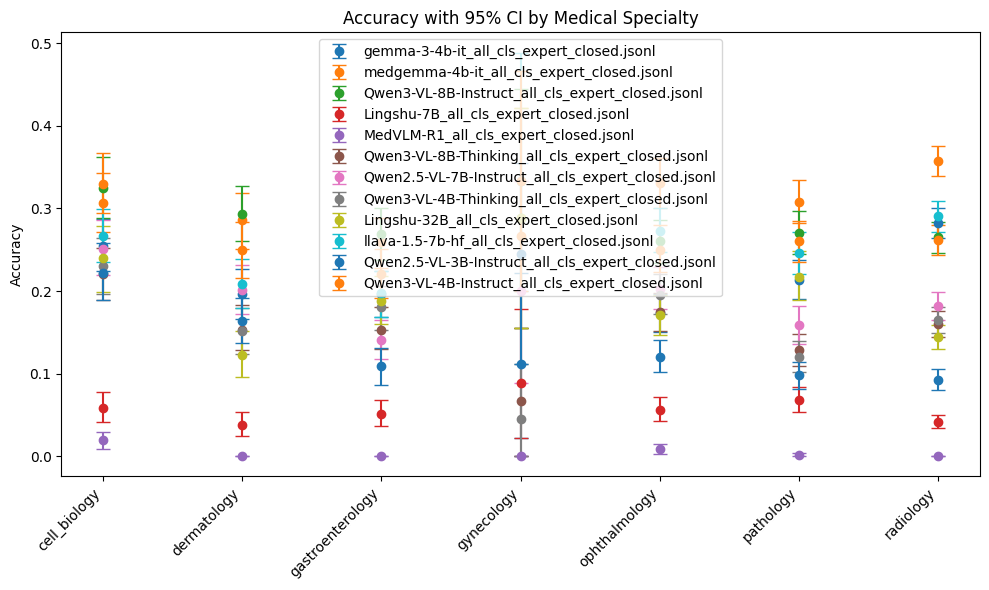

In [375]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

for key, df in out_metrics.items():
    plt.errorbar(
        df['medical_specialty'],
        df['accuracy_mean'],
        yerr=[df['accuracy_mean'] - df['accuracy_ci_lower'], df['accuracy_ci_upper'] - df['accuracy_mean']],
        fmt='o',  # marker style
        capsize=5,  # size of error bar caps
        label=key
    )

plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy with 95% CI by Medical Specialty')
plt.legend()
plt.tight_layout()
plt.show()


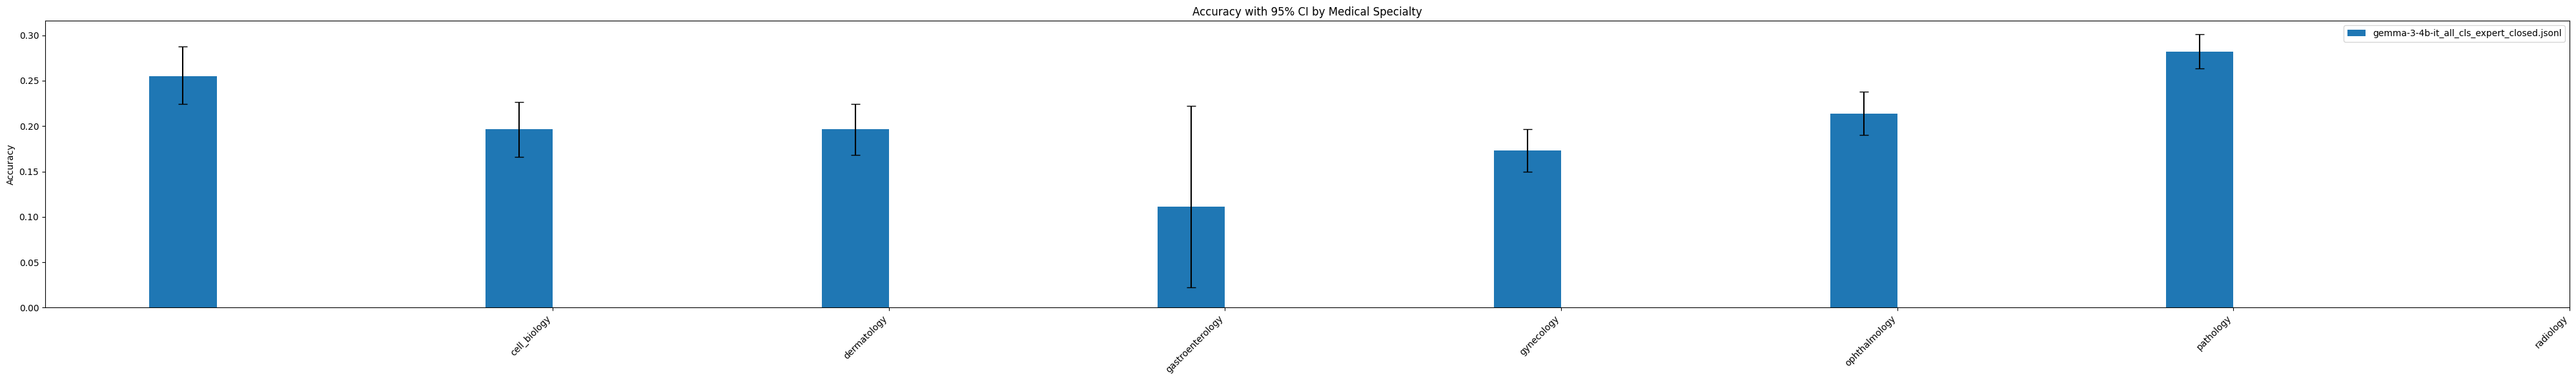

In [376]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(40, 6))

width = 0.2  # width of the bars
specialties = out_metrics[list(out_metrics.keys())[0]]['medical_specialty']
x = np.arange(len(specialties))

for i, (key, df) in enumerate(out_metrics.items()):
    plt.bar(
        x + i*width,
        df['accuracy_mean'],
        yerr=[df['accuracy_mean'] - df['accuracy_ci_lower'], df['accuracy_ci_upper'] - df['accuracy_mean']],
        width=width,
        capsize=5,
        label=key
    )
    break

plt.xticks(x + width*(len(out_metrics)-1)/2, specialties, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy with 95% CI by Medical Specialty')
plt.legend()
plt.tight_layout()
plt.show()


In [361]:
out_metrics

{'gemma-3-4b-it_all_cls_expert_closed.jsonl':   medical_specialty  f1_score_mean  f1_score_ci_lower  f1_score_ci_upper  \
 0      cell_biology       0.180115           0.153316           0.204344   
 1       dermatology       0.157055           0.127694           0.181046   
 2  gastroenterology       0.167042           0.139829           0.184988   
 3        gynecology       0.094376           0.025974           0.154144   
 4     ophthalmology       0.142091           0.119963           0.160052   
 5         pathology       0.184894           0.161637           0.202194   
 6         radiology       0.257681           0.234345           0.265922   
 
    accuracy_mean  accuracy_ci_lower  accuracy_ci_upper  
 0       0.255132           0.224340           0.287390  
 1       0.196375           0.166163           0.226586  
 2       0.196429           0.168367           0.224490  
 3       0.111111           0.022222           0.222222  
 4       0.173293           0.149847           

In [357]:
model_name_map = {f: f.replace('_all_cls_expert_closed.jsonl', '') for f in out_metrics.keys()}


In [358]:
model_name_map

{'gemma-3-4b-it_all_cls_expert_closed.jsonl': 'gemma-3-4b-it',
 'medgemma-4b-it_all_cls_expert_closed.jsonl': 'medgemma-4b-it',
 'Qwen3-VL-8B-Instruct_all_cls_expert_closed.jsonl': 'Qwen3-VL-8B-Instruct',
 'Lingshu-7B_all_cls_expert_closed.jsonl': 'Lingshu-7B',
 'MedVLM-R1_all_cls_expert_closed.jsonl': 'MedVLM-R1',
 'Qwen3-VL-8B-Thinking_all_cls_expert_closed.jsonl': 'Qwen3-VL-8B-Thinking',
 'Qwen2.5-VL-7B-Instruct_all_cls_expert_closed.jsonl': 'Qwen2.5-VL-7B-Instruct',
 'Qwen3-VL-4B-Thinking_all_cls_expert_closed.jsonl': 'Qwen3-VL-4B-Thinking',
 'Lingshu-32B_all_cls_expert_closed.jsonl': 'Lingshu-32B',
 'llava-1.5-7b-hf_all_cls_expert_closed.jsonl': 'llava-1.5-7b-hf',
 'Qwen2.5-VL-3B-Instruct_all_cls_expert_closed.jsonl': 'Qwen2.5-VL-3B-Instruct',
 'Qwen3-VL-4B-Instruct_all_cls_expert_closed.jsonl': 'Qwen3-VL-4B-Instruct'}

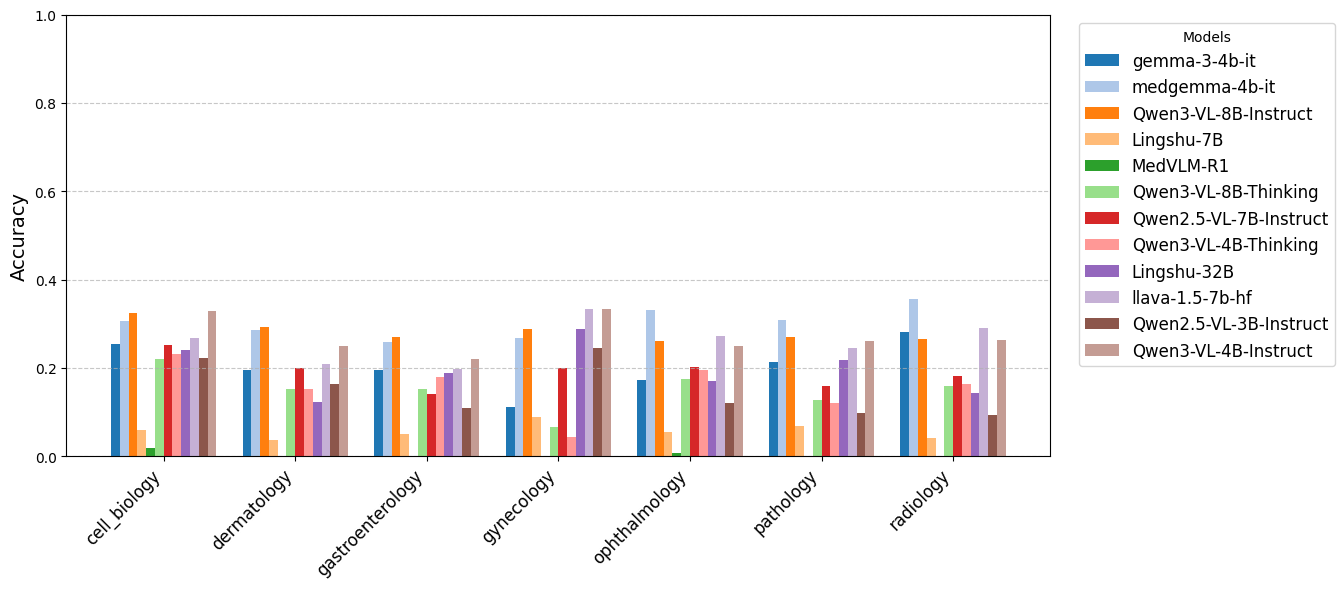

In [371]:
import matplotlib.pyplot as plt
import numpy as np

specialties = out_metrics[list(out_metrics.keys())[0]]['medical_specialty']
num_specialties = len(specialties)
num_models = len(out_metrics)

x = np.arange(num_specialties)
width = 0.8 / num_models  # width of each bar

plt.figure(figsize=(max(16, num_specialties*0.6), 6))
colors = plt.cm.tab20.colors  # 20 distinct colors

for i, (key, df) in enumerate(out_metrics.items()):
    plt.bar(
        x + i*width,
        df['accuracy_mean'],
        # yerr=[df['accuracy_mean'] - df['accuracy_ci_lower'], df['accuracy_ci_upper'] - df['accuracy_mean']],
        width=width,
        color=colors[i % len(colors)],
        label=model_name_map.get(key, key)  # use cleaned model name
    )

plt.xticks(x + width*(num_models-1)/2, specialties, rotation=45, ha='right', fontsize=12)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.legend(title="Models", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


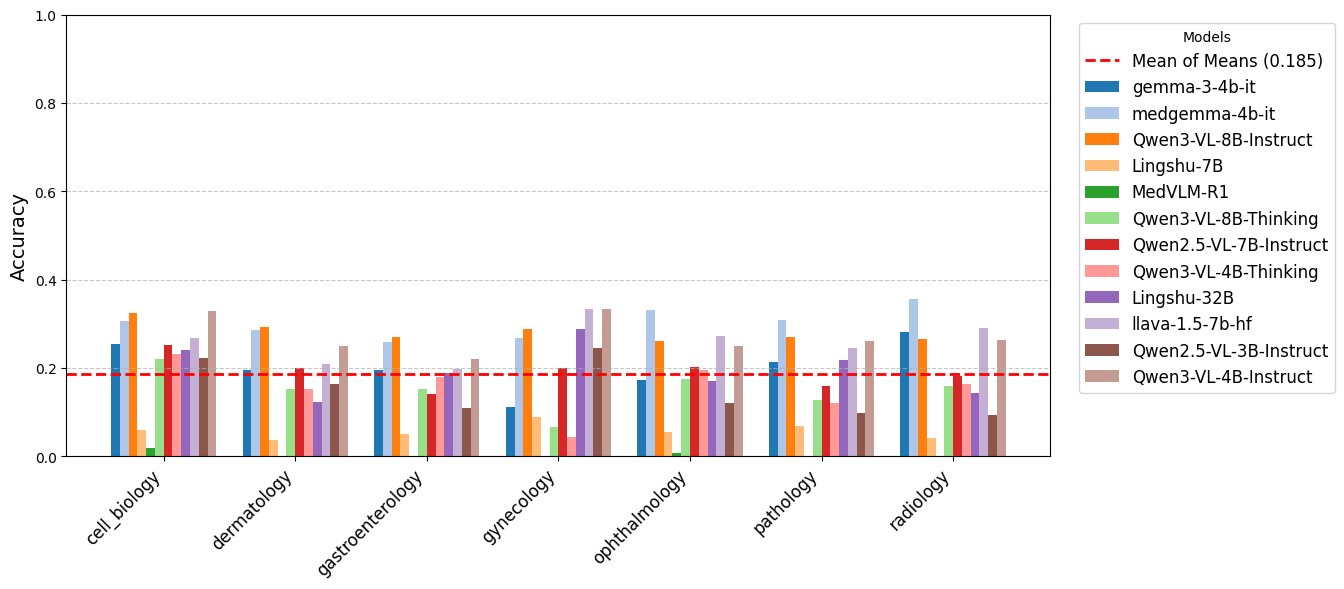

In [372]:
import matplotlib.pyplot as plt
import numpy as np

specialties = out_metrics[list(out_metrics.keys())[0]]['medical_specialty']
num_specialties = len(specialties)
num_models = len(out_metrics)

x = np.arange(num_specialties)
width = 0.8 / num_models  # width of each bar

plt.figure(figsize=(max(16, num_specialties*0.6), 6))
colors = plt.cm.tab20.colors  # 20 distinct colors

# Plot bars for each model
for i, (key, df) in enumerate(out_metrics.items()):
    plt.bar(
        x + i*width,
        df['accuracy_mean'],
        width=width,
        color=colors[i % len(colors)],
        label=model_name_map.get(key, key)
    )

# Plot mean of means
all_means = np.concatenate([df['accuracy_mean'].values for df in out_metrics.values()])
mean_of_means = all_means.mean()
plt.axhline(mean_of_means, color='red', linestyle='--', linewidth=2, label=f'Mean of Means ({mean_of_means:.3f})')

plt.xticks(x + width*(num_models-1)/2, specialties, rotation=45, ha='right', fontsize=12)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.legend(title="Models", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


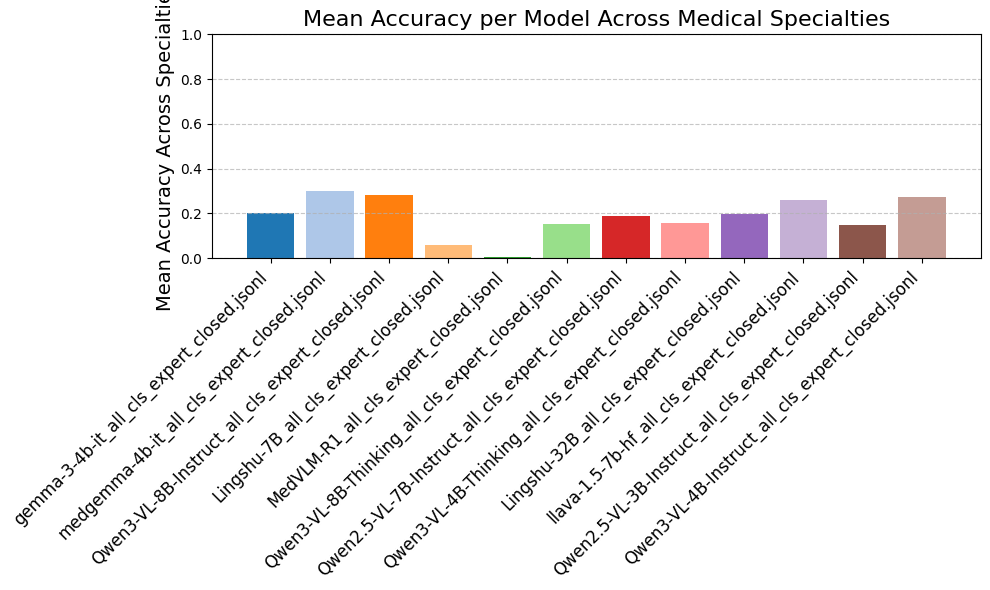

In [374]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(out_metrics.keys())
num_models = len(model_names)

# Calculate mean accuracy per model across all specialties
mean_accuracies = [df['accuracy_mean'].mean() for df in out_metrics.values()]

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20.colors

plt.bar(model_names, mean_accuracies, color=[colors[i % len(colors)] for i in range(num_models)])
plt.ylabel('Mean Accuracy Across Specialties', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Mean Accuracy per Model Across Medical Specialties', fontsize=16)
plt.tight_layout()
plt.show()
